## La primera parte, hasta asignacion fue extraida de https://github.com/clusterai/clusterai_2020

In [ ]:
# importamos las librerías necesarias para trabajar.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# importamos librerias de scikit learn para clasificacion y modelos de SVM.
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [3]:
# importamos librearias de Logistic Regression
from sklearn.linear_model import LogisticRegression

In [4]:
#Importamos librerias de Feature Selection
from sklearn.feature_selection import RFECV
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.linear_model import lasso_path
from sklearn.feature_selection import VarianceThreshold

In [5]:
# Importamos librerias de PCA
from sklearn.decomposition import PCA

In [6]:
pwd

'C:\\Users\\Usuario\\Google Drive\\2020\\Utn\\Ciencia de datos\\Clases\\clase_06'

# Importamos dataset de Wisconsin Breast Cancer

In [7]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
x = data.data
y = data.target

In [8]:
type(x)

numpy.ndarray

In [9]:
np.shape(x)

(569, 30)

In [10]:
type(x)

numpy.ndarray

In [11]:
np.shape(x)

(569, 30)

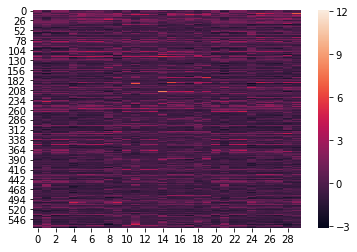

In [12]:
from sklearn.preprocessing import StandardScaler
sns.heatmap(StandardScaler().fit_transform(x))

# Separamos nuestros datos en Train y Test

In [13]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=4)

# Realizamos Auto Scaling

In [14]:
# Step 4: auto scaling train- set (mean = 0, std = 1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(xtrain)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [15]:
xtrain_scal = scaler.transform(xtrain)  
xtest_scal = scaler.transform(xtest)  

In [16]:
xtrain_scal.shape

(398, 30)

# Analisis de Componentes Principales (PCA)
Vamos a obtener primeros 10 autovalores y autovectores (eigenvalues y eigenvectors) de la matriz de train "xtrain_scal". 

In [17]:
from sklearn.decomposition import PCA
# cantidad de componentes a extraer
n_comps = 10
# definimos PCA
pca = PCA(n_components= n_comps)
# fit_transform del PCA a nuestros datos
xpca = pd.DataFrame(pca.fit_transform(xtrain_scal))
#xpca es el espacio latente Z
# obtenemos los auto-valores
eigenvalues = pca.explained_variance_ratio_

In [18]:
#Cuanto me explica cada variable de la varianza
pca.explained_variance_ratio_

array([0.44604183, 0.18260156, 0.10040269, 0.06410772, 0.05566709,
       0.04241754, 0.02164451, 0.0159364 , 0.01278413, 0.01074278])

In [19]:
# observamos el shape de la matriz obtenida del PCA. Ver que nuestro dataset se redujo de 30 a 10 dimensiones
xpca.shape

(398, 10)

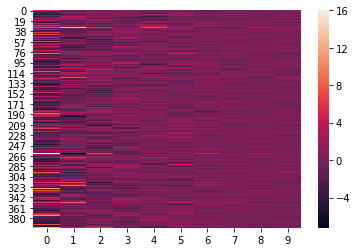

In [20]:
#Para ver como va bajando la  varianza entre valores
sns.heatmap(xpca)

# Observamos los autovalores obtenidos del PCA
Recordemos que los autovalores significa la variabilidad que "atrapa" cada componente principal. Obviamente siempre vamos a priorizar las componentes principales que mayor variabilidad capten de los datos de entrenamiento.

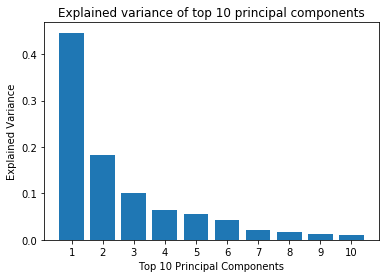

In [21]:
components = range(1,n_comps + 1)
plt.bar(components,eigenvalues)
plt.xticks(components)
plt.title('Explained variance of top '+ str(n_comps) + ' principal components')
plt.xlabel('Top '+ str(n_comps) + ' Principal Components')
plt.ylabel('Explained Variance')
plt.show()

# Scatter plot del PCA
Con las 2 primeras componentes principales **antes** de la selección de variables visualizamos nuestras muestras/samples de train. **Atencion!** vean que estamos visualizando datos de 30 dimensiones en solamente 2 :). Otro punto importante es que con las dos primeras componentes principales captamos el 65 % aprox de la variabilidad de mis datos (hacer explained variance de PC1 + PC2)

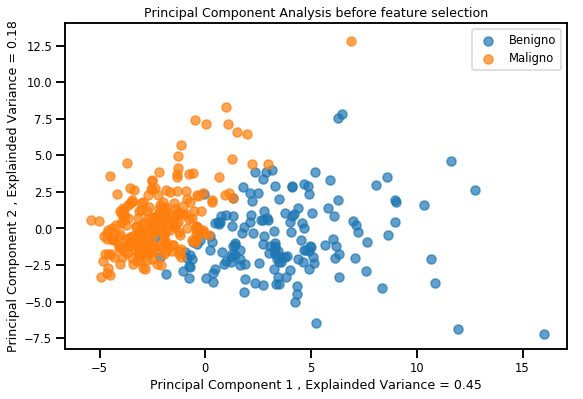

In [22]:
sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(9,6))
plt.scatter(xpca.loc[(ytrain == 0).ravel(),0],xpca.loc[(ytrain == 0).ravel(),1], alpha = 0.7, label = 'Benigno')
plt.scatter(xpca.loc[(ytrain == 1).ravel(),0],xpca.loc[(ytrain == 1).ravel(),1], alpha = 0.7, label = 'Maligno')
plt.xlabel('Principal Component 1 , Explainded Variance = ' + str(np.round(eigenvalues[0],2)))
plt.ylabel('Principal Component 2 , Explainded Variance = ' + str(np.round(eigenvalues[1],2)))
plt.title('Principal Component Analysis before feature selection')
plt.legend(loc='upper right')
plt.show()

Estamos visualizando datos de alta dimension en 2 dimensiones :):):):). Ojo que con las dos primeras componentes visualizamos el 63% de la variabilidad del dataset original. Es decir que sirve para darnos una idea aunque lo que se aconseja es quedarse con las componentes que acumulan aunque sea el 80% de la variabilidad original.

In [23]:
# vamos a visualizar en 3d
from mpl_toolkits.mplot3d import Axes3D

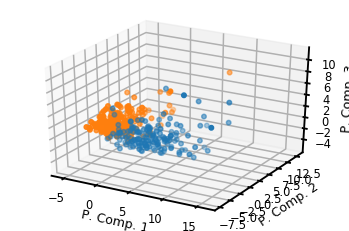

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xpca.iloc[(ytrain == 0).ravel(),0], xpca.iloc[(ytrain == 0).ravel(),1], xpca.iloc[(ytrain == 0).ravel(),2])
ax.scatter(xpca.iloc[(ytrain == 1).ravel(),0], xpca.iloc[(ytrain == 1).ravel(),1], xpca.iloc[(ytrain == 1).ravel(),2])
ax.set_xlabel('P. Comp. 1')
ax.set_ylabel('P. Comp. 2')
ax.set_zlabel('P. Comp. 3')
plt.show()

# kernel-PCA

Computamos el desvio standard de cada feature. Luego decidimos quedarnos con aquellas cuyo STDEV sea mayor a un cuantil determinado. Eso resultara de un vector "mascara" booleano que nos serirá para filtrar el dataset original. Vean que este metodo es no supervisado aunque su debilidad es que es univariado.

In [25]:
from sklearn.decomposition import PCA, KernelPCA

In [26]:
# cantidad de componentes a extraer
#el máximo numero de componentes es la cantidad de muestras
n_comps = 10
# definimos PCA
kpca = KernelPCA(n_components= n_comps, kernel = 'rbf', gamma = 0.14)
#a medida que gama se hacerca a 0 se parece mas al lineal, PCA solo 
# fit_transform del PCA a nuestros datos
xkpca = pd.DataFrame(kpca.fit_transform(xtrain_scal))
#xkpca es el espacio latente Z

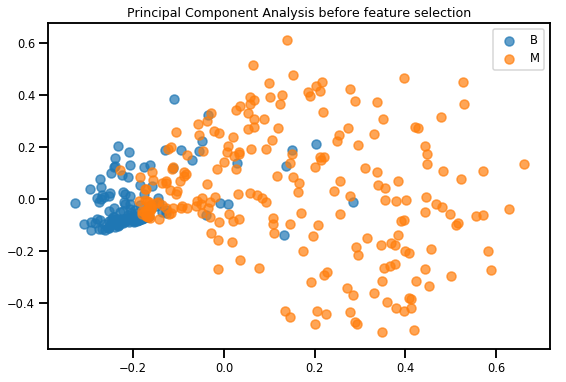

In [27]:
sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(9,6))
plt.scatter(xkpca.loc[(ytrain == 0).ravel(),0],xkpca.loc[(ytrain == 0).ravel(),1], alpha = 0.7, label = 'B')
plt.scatter(xkpca.loc[(ytrain == 1).ravel(),0],xkpca.loc[(ytrain == 1).ravel(),1], alpha = 0.7, label = 'M')
#plt.xlabel('Principal Component 1 , Explainded Variance = ' + str(np.round(eigenvalues[0],2)))
#plt.ylabel('Principal Component 2 , Explainded Variance = ' + str(np.round(eigenvalues[1],2)))
plt.title('Principal Component Analysis before feature selection')
plt.legend(loc='upper right')
plt.show()

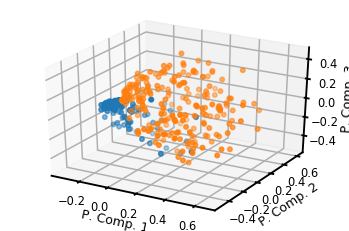

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xkpca.iloc[(ytrain == 0).ravel(),0], xkpca.iloc[(ytrain == 0).ravel(),1], xkpca.iloc[(ytrain == 0).ravel(),2])
ax.scatter(xkpca.iloc[(ytrain == 1).ravel(),0], xkpca.iloc[(ytrain == 1).ravel(),1], xkpca.iloc[(ytrain == 1).ravel(),2])
ax.set_xlabel('P. Comp. 1')
ax.set_ylabel('P. Comp. 2')
ax.set_zlabel('P. Comp. 3')
plt.show()

# Asignacion 01:
Partiendo de los datos originales crear un nuevo train-test split donde train es el 10% de los datos. Reducir la dimension con PCA y kPCA. Clasificar usando las proyecciones obtenidas con logistic regression. Medir la calidad de la clasificacion en area debajo de la curva y accuracy.

## Separo train  test

In [127]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.1, random_state=4)

## Defino escalador en funcion de train

In [128]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(xtrain)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

## Escalo xtrain y xtest con el escaler definido

In [129]:
xtrain_scal2 = scaler.transform(xtrain)  
xtest_scal2 = scaler.transform(xtest) 

# PCA

### Aplico PCA sobre xtrain

In [130]:
from sklearn.decomposition import PCA
# cantidad de componentes a extraer, es un hyperparametro
n_comps = 5
# definimos PCA
pca = PCA(n_components= n_comps)
pca.fit(xtrain_scal2)
# fit_transform del PCA a nuestros datos
zpca_train=pca.transform(xtrain_scal2)
zpca_test=pca.transform(xtest_scal2)
# obtenemos los auto-valores, para devolvernos que ariabilidad tiene cada autovalor
eigenvalues = pca.explained_variance_ratio_

## Defino clasificador de regresión logística, y entreno (fitteo)

In [131]:
lr_pca = LogisticRegression(solver = 'lbfgs')
lr_pca.fit(zpca_train, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

## Predigo los valores del "TEST"

In [132]:
ypred_pca = lr_pca.predict(zpca_test)

## Calculo Accuracy, entre ypred e Y test

In [133]:
acc_lr_pca =  accuracy_score(ypred_pca, ytest)
acc_lr_pca

0.9473684210526315

# Kernel - PCA

### Aplico KPCA sobre xtrain

In [187]:
# cantidad de componentes a extraer
#el máximo numero de componentes es la cantidad de muestras
n_comps = 10
# definimos KPCA
kpca = KernelPCA(n_components= n_comps, kernel = 'rbf', gamma = 0.001)
kpca.fit(xtrain_scal2)
# fit_transform del PCA a nuestros datos
zkpca_train2=kpca.transform(xtrain_scal2)
zkpca_test2=kpca.transform(xtest_scal2)
#xkpca es el espacio latente Z


## Defino clasificador de regresión logística, y entreno (fitteo)

In [188]:
lr_kpca = LogisticRegression(solver = 'lbfgs')
lr_kpca.fit(zkpca_train2, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

## Predigo los valores del "TEST"

In [189]:
ypred_kpca = lr_kpca.predict(zkpca_test2)

## Calculo Accuracy, entre ypred e Y test

In [190]:
acc_lr_pca =  accuracy_score(ypred_kpca, ytest)
acc_lr_pca

0.9649122807017544